# Feature Engineering

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from tqdm.notebook import tqdm
from sklearn.impute import KNNImputer

from service_func.service_func import *

## Предобработка, начало: замена пропущенных значений и восстановление методом knn

In [ ]:
member = pd.read_csv('data/members.csv')
print(member.shape)
member.head(3)

(34403, 7)


,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712


In [ ]:
# переводим возраст меньший либо равный нулю в nan.
# обрабатываем также и большой возраст
# дату разбиваем в три численных столбца
new_data = age_replace(member)
new_data = get_d_m_y(new_data)
print(new_data.shape)
new_data.head(3)

(34403, 12)


,msno,city,bd,gender,registered_via,new_bd,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,NaN,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,NaN,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,NaN,2016,4,11,2017,7,12


In [ ]:
new_data = new_data[['city','new_bd','registered_via' , 'regi_day' ,'regi_month' , 'regi_year' ,'expire_day','expire_month' ,'expire_year' ]]
print(new_data.shape)
new_data.head(3)

(34403, 9)


,city,new_bd,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year
0,1,NaN,7,2011,8,20,2017,9,20
1,1,NaN,7,2015,6,28,2017,6,22
2,1,NaN,4,2016,4,11,2017,7,12


In [ ]:
imputer = KNNImputer(n_neighbors=10)
imputer.fit(new_data)

KNNImputer(n_neighbors=10)

In [14]:
start = time.time()
X = imputer.transform(new_data)
print((time.time() - start) /  60)

In [ ]:
for i in range(len(new_data.columns)):
    new_data[new_data.columns[i]] = X[:,i]
print(new_data.shape)
new_data.head(3)

(34403, 9)


,city,new_bd,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year
0,1.0,31.7,7.0,2011.0,8.0,20.0,2017.0,9.0,20.0
1,1.0,26.3,7.0,2015.0,6.0,28.0,2017.0,6.0,22.0
2,1.0,28.8,4.0,2016.0,4.0,11.0,2017.0,7.0,12.0


### До обработки поля bd

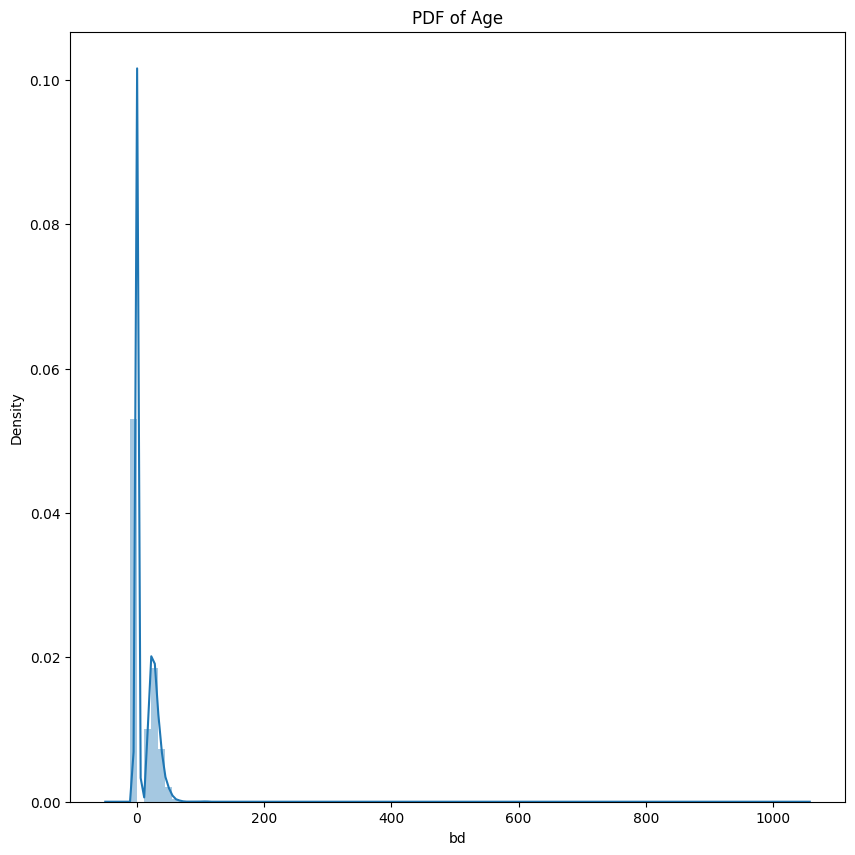

In [ ]:
plt.figure(figsize = (10,10))
ax = sns.distplot(member['bd'], bins = 100,hist = True)
#h,l = ax.get_legend_handles_labels()
#ax.legend(h ,l,bbox_to_anchor=(1.05, 1) ,loc = 'upper left')
#plt.setp(ax.get_xticklabels() , rotation = 90 )
plt.title('PDF of {}'.format("Age"))
plt.show()

### После обработки bd

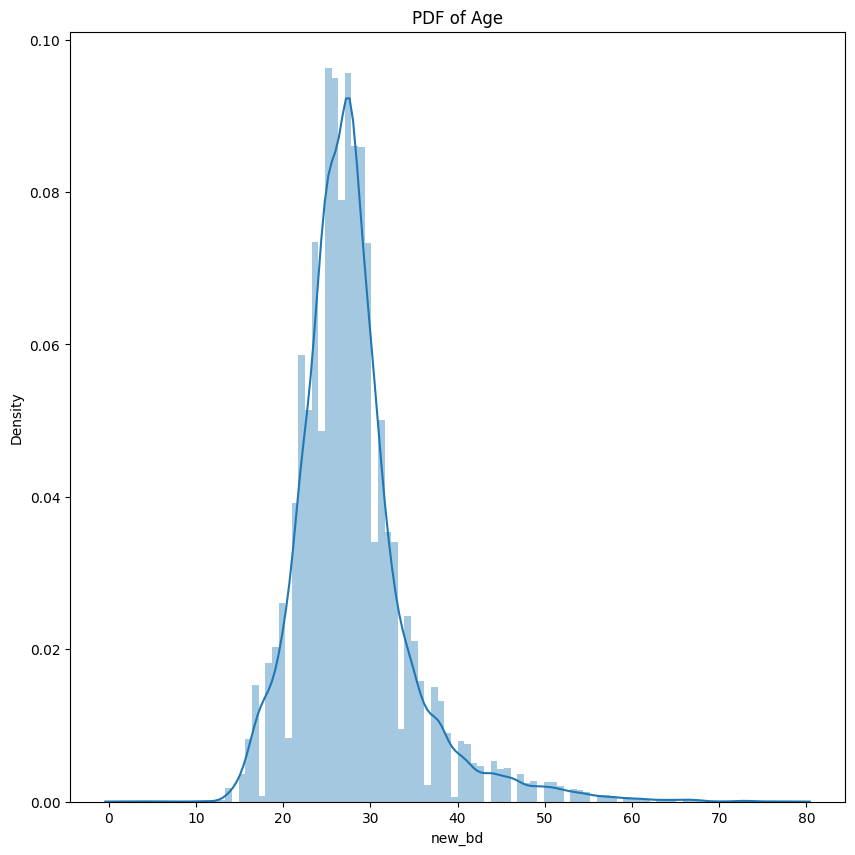

In [ ]:
plt.figure(figsize = (10,10))
ax = sns.distplot(new_data['new_bd'], bins = 100,hist = True)
#h,l = ax.get_legend_handles_labels()
#ax.legend(h ,l,bbox_to_anchor=(1.05, 1) ,loc = 'upper left')
#plt.setp(ax.get_xticklabels() , rotation = 90 )
plt.title('PDF of {}'.format("Age"))
plt.show()

In [ ]:
member['imputed_bd'] = new_data['new_bd']
member = member.drop('new_bd', axis = 1)
print(member.shape)
member.head(3)

(34403, 14)


,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920,2011,8,20,2017,9,20,31.7
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622,2015,6,28,2017,6,22,26.3
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712,2016,4,11,2017,7,12,28.8


In [ ]:
member.to_csv('data/new_member.csv')

## Merge all files

In [ ]:
# merge data
member = pd.read_csv('data/new_member.csv')
print('member shape :',member.shape)

train = pd.read_csv('data/train.csv')
print('train shape :',train.shape)

song_extra_info = pd.read_csv('data/song_extra_info.csv')
print('song_extra_info shape :',song_extra_info.shape)

songs = pd.read_csv('data/songs.csv')
print('songs shape :' , songs.shape)

songs_info = songs.merge(song_extra_info, how='left', on='song_id')
train_member = train.merge(member , how = 'left' , on = 'msno')
train_data = train_member.merge(songs_info, how='left', on='song_id')
print('train_data shape :',train_data.shape)

member shape : (34403, 15)
train shape : (7377418, 6)
song_extra_info shape : (2295971, 3)
songs shape : (2296320, 7)
train_data shape : (7377418, 28)


In [ ]:
test = pd.read_csv('data/test.csv')
print('test shape :',test.shape)

# merge data on test file
test_member = test.merge(member , how = 'left' , on = 'msno')
test_data = test_member.merge(songs_info, how='left', on='song_id')
print('test data shape :',test_data.shape)

test shape : (2556790, 6)
test data shape : (2556790, 28)


In [ ]:
# remove columns which name start with 'Unnamed:'
train_data = remove_funtion(train_data)
print(train_data.shape)
train_data.head(3)

(7377418, 27)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,expire_year,imputed_bd,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,...,5,28.3,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,11,24.0,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,11,24.0,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761


In [ ]:
test_data = remove_funtion(test_data)
print(test_data.shape)
test_data.head(1)

(2556790, 27)


,id,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,...,expire_year,imputed_bd,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,NaN,7,...,18,23.3,224130.0,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0,愛其實很殘忍,TWUM71400047


# train_test_split

In [ ]:
print(train_data.shape)
print(test_data.shape)

(7377418, 27)
(2556790, 27)


In [ ]:
split_val = round((80 * 7377418) / 100)
split_val

5901934

In [ ]:
# split data
val_data   = train_data[split_val:]
train_data = train_data[:split_val]

print(train_data.shape , val_data.shape , test_data.shape)

(5901934, 27) (1475484, 27) (2556790, 27)


In [ ]:
# separate genre_ids and make seprate columns for each genre_ids
def separate_genre(data):
    genre = data['genre_ids'].values
    genre_category  = []

    # seprate all genre and store in genre_category
    for i in genre:
        lis = []
        i = str(i)
        if '|' in i:
            sen = i.split('|')
            genre_category.append(sen)
        else:
            lis.append(i)
            genre_category.append(lis)
    # if len(genre) < 8 than fill 0 to make all len(genre) == 8        
    genre_id_list = []
    for i in genre_category:
        while len(i) < 8:
            i.append(0)
        genre_id_list.append(i)

    genre_ids = np.array(genre_id_list)

    # make seprate columns for all genre_ids 
    data['one_genre']   = genre_ids[:,0]
    data['two_genre']   = genre_ids[:,1] 
    data['three_genre'] = genre_ids[:,2]
    data['four_genre']  = genre_ids[:,3]
    data['five_genre']  = genre_ids[:,4]
    data['six_genre']   = genre_ids[:,5]
    data['seven_genre'] = genre_ids[:,6]
    data['eight_genre'] = genre_ids[:,7]

    #data = data.drop('genre_ids' , axis = 1)

    return data

In [ ]:
# separate genre_ids and make seprate columns for each genre_ids
train_data = separate_genre(train_data)
val_data   = separate_genre(val_data)
test_data  = separate_genre(test_data)

In [ ]:
print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 35)
Vali  Shape : (1475484, 35)
Test  shape : (2556790, 35)


## дальнейший Feature Engineering

In [ ]:
count_na(train_data)

,NA_count,Percentage
msno,0,0.000000
song_id,0,0.000000
source_system_tab,20018,0.339177
source_screen_name,322244,5.459973
source_type,16775,0.284229
target,0,0.000000
city,0,0.000000
bd,0,0.000000
gender,2346748,39.762356
registered_via,0,0.000000


In [ ]:
info(train_data)

columns_name            unique_values         Type
--------------------------------------------------
msno                       | 28026       | object
song_id                    | 319912      | object
source_system_tab          | 9           | object
source_screen_name         | 21          | object
source_type                | 12          | object
target                     | 2           | int64
city                       | 21          | int64
bd                         | 90          | int64
gender                     | 3           | object
registered_via             | 5           | int64
registration_init_time     | 3765        | int64
expiration_date            | 1318        | int64
regi_day                   | 14          | int64
regi_month                 | 12          | int64
regi_year                  | 31          | int64
expire_day                 | 18          | int64
expire_month               | 12          | int64
expire_year                | 31          | int64
imputed_bd

In [ ]:
#count_na(val_data)

In [ ]:
#info(val_data)

In [ ]:
#find_missing_values(test_data)
#info(test_data)

In [ ]:
# replace missing value with mode
mode_system_tab  = str(train_data[ 'source_system_tab'].mode()[0])
mode_source_type = str(train_data['source_type'].mode()[0])
mode_name        = str(train_data['name'].mode()[0])
mode_artist_name = str(train_data['artist_name'].mode()[0])
mode_language    = str(train_data['language'].mode()[0])

print( 'Mode of source_system_tab :',mode_system_tab)
print( 'Mode of source_type       :',mode_source_type)
print( 'Mode of name              :',mode_name)
print( 'Mode of artist_name       :',mode_artist_name)
print( 'Mode of language          :',mode_language)

Mode of source_system_tab : my library
Mode of source_type       : local-library
Mode of name              : 演員
Mode of artist_name       : Various Artists
Mode of language          : 3.0


# Обработка пропущенных значений

* If Missing value rate is < 1% than we will fill with mode of that feature.
* For Categorical feature we will define nan values as 'not_define' categories.
* For Numeric categorical feature we will fill with 0.
* For Numeric (continuous variable) values we will fill with median.

In [ ]:
# replace missing values with new category EX- for categorical data fill not_define and for numerical data fill zeros.
train_data['composer'] = train_data['composer'].fillna('no_name')
val_data['composer'] = val_data['composer'].fillna('no_name')
test_data['composer'] = test_data['composer'].fillna('no_name')

train_data['lyricist'] = train_data['lyricist'].fillna('no_name')
val_data['lyricist'] = val_data['lyricist'].fillna('no_name')
test_data['lyricist'] = test_data['lyricist'].fillna('no_name')

train_data['source_screen_name'] = train_data['source_screen_name'].fillna('not_define')
val_data['source_screen_name'] = val_data['source_screen_name'].fillna('not_define')
test_data['source_screen_name'] = test_data['source_screen_name'].fillna('not_define')

train_data['gender'] = train_data['gender'].fillna('not_define')
val_data['gender'] = val_data['gender'].fillna('not_define')
test_data['gender'] = test_data['gender'].fillna('not_define')

# for numeric feature
train_data['isrc'] = train_data['isrc'].fillna('0')
val_data['isrc'] = val_data['isrc'].fillna('0')
test_data['isrc'] = test_data['isrc'].fillna('0')

# replace missing values with mode 
train_data['source_system_tab'] = train_data['source_system_tab'].fillna(mode_system_tab)
val_data['source_system_tab'] = val_data['source_system_tab'].fillna(mode_system_tab)
test_data['source_system_tab'] = test_data['source_system_tab'].fillna(mode_system_tab)

train_data['source_type'] = train_data['source_type'].fillna(mode_source_type)
val_data['source_type'] = val_data['source_type'].fillna(mode_source_type)
test_data['source_type'] = test_data['source_type'].fillna(mode_source_type)

train_data['name'] = train_data['name'].fillna(mode_name)
val_data['name'] = val_data['name'].fillna(mode_name)
test_data['name'] = test_data['name'].fillna(mode_name)

train_data['song_length'] = train_data['song_length'].fillna(train_data['song_length'].median())
val_data['song_length'] = val_data['song_length'].fillna(train_data['song_length'].median())
test_data['song_length'] = test_data['song_length'].fillna(train_data['song_length'].median())

train_data['artist_name'] = train_data['artist_name'].fillna(mode_artist_name)
val_data['artist_name'] = val_data['artist_name'].fillna(mode_artist_name)
test_data['artist_name'] = test_data['artist_name'].fillna(mode_artist_name)

train_data['language'] = train_data['language'].fillna(mode_language)
val_data['language'] = val_data['language'].fillna(mode_language)
test_data['language'] = test_data['language'].fillna(mode_language)

In [ ]:
train_data.isnull().any()

msno                      False
song_id                   False
source_system_tab         False
source_screen_name        False
source_type               False
target                    False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
expiration_date           False
regi_day                  False
regi_month                False
regi_year                 False
expire_day                False
expire_month              False
expire_year               False
imputed_bd                False
song_length               False
genre_ids                  True
artist_name               False
composer                  False
lyricist                  False
language                  False
name                      False
isrc                      False
one_genre                 False
two_genre                 False
three_genre               False
four_genre                False
five_gen

In [ ]:
val_data.isnull().any()

msno                      False
song_id                   False
source_system_tab         False
source_screen_name        False
source_type               False
target                    False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
expiration_date           False
regi_day                  False
regi_month                False
regi_year                 False
expire_day                False
expire_month              False
expire_year               False
imputed_bd                False
song_length               False
genre_ids                  True
artist_name               False
composer                  False
lyricist                  False
language                  False
name                      False
isrc                      False
one_genre                 False
two_genre                 False
three_genre               False
four_genre                False
five_gen

In [ ]:
test_data.isnull().any()

id                        False
msno                      False
song_id                   False
source_system_tab         False
source_screen_name        False
source_type               False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
expiration_date           False
regi_day                  False
regi_month                False
regi_year                 False
expire_day                False
expire_month              False
expire_year               False
imputed_bd                False
song_length               False
genre_ids                  True
artist_name               False
composer                  False
lyricist                  False
language                  False
name                      False
isrc                      False
one_genre                 False
two_genre                 False
three_genre               False
four_genre                False
five_gen

# Feature Extraction

In [ ]:
print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 35)
Vali  Shape : (1475484, 35)
Test  shape : (2556790, 35)


In [ ]:
mean = train_data['song_length'].mean()

train_data = song_len(train_data, mean)
val_data   = song_len(val_data, mean)
test_data  = song_len(test_data, mean)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 36)
Vali  Shape : (1475484, 36)
Test  shape : (2556790, 36)


In [ ]:
# create new feature 
# if language = 3 or 52 than 1 else: 0
# we know that most song language are 3 or 52.
    
train_data = like_language(train_data)
val_data   = like_language(val_data)
test_dat   = like_language(test_data)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 37)
Vali  Shape : (1475484, 37)
Test  shape : (2556790, 37)


In [ ]:
# create new feature : count of composer artist
train_composer_count = []
for i in train_data['composer']:
    s = count_funtion(i,'no_name')
    train_composer_count.append(s)
train_data['composer_count'] = train_composer_count

val_composer_count = []
for i in val_data['composer']:
    s = count_funtion(i,'no_name')
    val_composer_count.append(s)
val_data['composer_count'] = val_composer_count

test_composer_count = []
for i in test_data['composer']:
    s = count_funtion(i,'no_name')
    test_composer_count.append(s)
test_data['composer_count'] = test_composer_count

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 38)
Vali  Shape : (1475484, 38)
Test  shape : (2556790, 38)


In [ ]:
# create new feature : count of lyricist artist

train_lyricist_count = []
for i in train_data['lyricist']:
    s = count_funtion(i,'no_name')
    train_lyricist_count.append(s)
train_data['lyricist_count'] = train_lyricist_count

val_lyricist_count = []
for i in val_data['lyricist']:
    s = count_funtion(i,'no_name')
    val_lyricist_count.append(s)
val_data['lyricist_count'] = val_lyricist_count

test_lyricist_count = []
for i in test_data['lyricist']:
    s = count_funtion(i,'no_name')
    test_lyricist_count.append(s)
test_data['lyricist_count'] = test_lyricist_count

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 39)
Vali  Shape : (1475484, 39)
Test  shape : (2556790, 39)


In [ ]:
# funtion return how many genre_ids we have in each row 
genre = train_data['genre_ids'].values
max_genre = []

for i in genre:
    i = str(i)
    max_genre.append(len(i.split('|')))
    
for i in range(1,max(max_genre)+1):
    c = str(max_genre.count(i))
    print(c ,' '*(6-len(c))  , 'rows have' , i , 'genre_ids')

5626314  rows have 1 genre_ids
242213  rows have 2 genre_ids
26516   rows have 3 genre_ids
5020    rows have 4 genre_ids
1616    rows have 5 genre_ids
32      rows have 6 genre_ids
10      rows have 7 genre_ids
213     rows have 8 genre_ids


In [ ]:
# get first name of composer

train_data = get_composer_name(train_data)
val_data   = get_composer_name(val_data)
test_data  = get_composer_name(test_data)  

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 40)
Vali  Shape : (1475484, 40)
Test  shape : (2556790, 40)


In [ ]:
# get first name of artist_name

train_data = get_artist_name(train_data)
val_data   = get_artist_name(val_data)
test_data  = get_artist_name(test_data)  

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 41)
Vali  Shape : (1475484, 41)
Test  shape : (2556790, 41)


In [ ]:
# funtion for extract values from isrc feature

train_data = get_isrc(train_data)
val_data   = get_isrc(val_data)
test_data  = get_isrc(test_data)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 45)
Vali  Shape : (1475484, 45)
Test  shape : (2556790, 45)


[Reference for below feature](https://www.researchgate.net/publication/328838360_KKbox%27s_Music_Recommendation_Challenge_Solution_with_Feature_engineering_11th_ACM_International_Conference_on_Web_Search_and_Data_Mining_WSDM_2018_February_5-9_2018_Los_Angeles_California_USA_WSDM_Cup
)

* Reseach paper : KKbox’s Music Recommendation Challenge Solution with Feature engineering 

In [ ]:
# create new feature 
# we know that young people prefer new songs and older are more like to listen older songs.
# new_feature that represent gap between user age and song release year

train_data['age_gap_between_song'] = train_data['bd'].astype(float) - train_data['year'].astype(float)
 
val_data['age_gap_between_song'] = val_data['bd'].astype(float) - val_data['year'].astype(float)
 
test_data['age_gap_between_song'] = test_data['bd'].astype(float) - test_data['year'].astype(float)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 46)
Vali  Shape : (1475484, 46)
Test  shape : (2556790, 46)


In [ ]:
print(train_data.shape)
train_data.head(3)

(5901934, 46)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,like_language,composer_count,lyricist_count,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,not_define,7,...,1,2,0,Dan Smith,Bastille,GB,UM7,16,02854,-16.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,1,0,0,no_name,Various Artists,US,3C6,99,10183,-75.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,1,4,0,N. Jones,Nas,US,UM7,06,18761,18.0


In [ ]:
# https://github.com/lystdo/Codes-for-WSDM-CUP-Music-Rec-1st-place-solution

train_data = calculate_groupby_features(train_data)
val_data = calculate_groupby_features(val_data)
test_data = calculate_groupby_features(test_data)

In [ ]:
train_data = calculate_groupby_features(train_data)
#print('.')
val_data = calculate_groupby_features(val_data)
print('..')
test_data = calculate_groupby_features(test_data)
print('...')

..
...


In [ ]:
print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 51)
Vali  Shape : (1475484, 51)
Test  shape : (2556790, 51)


In [ ]:
train_data.isnull().any()

msno                      False
song_id                   False
source_system_tab         False
source_screen_name        False
source_type               False
target                    False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
expiration_date           False
regi_day                  False
regi_month                False
regi_year                 False
expire_day                False
expire_month              False
expire_year               False
imputed_bd                False
song_length               False
genre_ids                  True
artist_name               False
composer                  False
lyricist                  False
language                  False
name                      False
isrc                      False
one_genre                 False
two_genre                 False
three_genre               False
four_genre                False
five_gen

In [ ]:
val_data.isnull().any()

msno                      False
song_id                   False
source_system_tab         False
source_screen_name        False
source_type               False
target                    False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
expiration_date           False
regi_day                  False
regi_month                False
regi_year                 False
expire_day                False
expire_month              False
expire_year               False
imputed_bd                False
song_length               False
genre_ids                  True
artist_name               False
composer                  False
lyricist                  False
language                  False
name                      False
isrc                      False
one_genre                 False
two_genre                 False
three_genre               False
four_genre                False
five_gen

In [ ]:
test_data.isnull().any()

id                        False
msno                      False
song_id                   False
source_system_tab         False
source_screen_name        False
source_type               False
city                      False
bd                        False
gender                    False
registered_via            False
registration_init_time    False
expiration_date           False
regi_day                  False
regi_month                False
regi_year                 False
expire_day                False
expire_month              False
expire_year               False
imputed_bd                False
song_length               False
genre_ids                  True
artist_name               False
composer                  False
lyricist                  False
language                  False
name                      False
isrc                      False
one_genre                 False
two_genre                 False
three_genre               False
four_genre                False
five_gen

In [ ]:
train_data = train_data.drop('genre_ids', axis=1)
val_data = val_data.drop('genre_ids', axis=1)
test_data = test_data.drop('genre_ids', axis=1)
test_data = test_data.drop('id', axis=1)

In [ ]:
print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 51)
Vali  Shape : (1475484, 51)
Test  shape : (2556790, 50)


In [ ]:
for c in list(train_data.columns):
    if c not in list(test_data.columns):
        print(c)

target
genre_ids


In [ ]:
#train_data.to_csv('train_data_final.csv')
#print('train_data saved.')
#val_data.to_csv('val_data_final.csv')
#print('val_data saved.')
test_data.to_csv('test_data_final.csv')
print('test_data saved.')

test_data saved.


In [ ]:
print(train_data.shape)
train_data.head(3)

(5901934, 50)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,not_define,7,...,GB,UM7,16,02854,-16.0,4313,904,1498090,196,2331999
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,US,3C6,99,10183,-75.0,581,237601,1498090,1,209830
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,US,UM7,06,18761,18.0,581,223,1498090,3,209830


In [ ]:
print(val_data.shape)
val_data.head(3)

(1475484, 50)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
5901934,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,JTVy3aCLoTFkqPK4pkGBy0YTlH0zpkubCoKMh07WYfM=,my library,Local playlist more,local-library,1,1,18,female,3,...,TW,J97,07,00301,11.0,149,67,792271,26,20746
5901935,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,2TR1fCpa5/ac/xe+hdOe52nBZ6afSU49gsGQbhTQVzk=,my library,Local playlist more,local-library,0,1,18,female,3,...,TW,D95,12,44101,6.0,149,792,792271,37,20746
5901936,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,wev1Fi6KYkCSFAstQfhxJPZv7wkn8wGepys+KDmeBy4=,my library,Local playlist more,local-library,1,1,18,female,3,...,US,UM7,16,03401,2.0,149,66251,366699,281,20746


In [ ]:
print(test_data.shape)
test_data.head(3)

(2556790, 49)


,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,...,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,not_define,7,20160219,...,TW,UM7,14,00047,-14.0,17,4009,1311328,196,1043221
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,1,0,not_define,7,20160219,...,TW,B67,10,05201,-10.0,17,31571,1311328,1479,1043221
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,not_define,song-based-playlist,1,0,not_define,4,20161117,...,JP,WP0,10,70260,-10.0,1,149,84227,2,1043221


# Label encoding

In [3]:
train_data = pd.read_csv('train_data_final.csv')
print('Train Shape :', train_data.shape)

Train Shape : (5901934, 51)


In [ ]:
val_data   = pd.read_csv('val_data_final.csv')
print('Vali  Shape :',val_data.shape)

Vali  Shape : (1475484, 51)


In [19]:
test_data  = pd.read_csv('test_data_final.csv')
print('Test  shape :',test_data.shape)

Test  shape : (2556790, 51)


In [20]:
#train_data = remove_funtion(train_data)
#val_data = remove_funtion(val_data)
test_data = remove_funtion(test_data)
test_data = test_data.drop('id', axis=1)

In [8]:
#print('Train Shape :', train_data.shape)
#print('Vali  Shape :', val_data.shape)
print('Test  shape :', test_data.shape)

Test  shape : (2556790, 50)


In [5]:
train_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,not_define,7,...,GB,UM7,16,02854,-16.0,4313,904,1498090,196,2331999
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,US,3C6,99,10183,-75.0,581,237601,1498090,1,209830
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,US,UM7,6,18761,18.0,581,223,1498090,3,209830
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,GB,UQH,10,00063,14.0,581,1,243239,1,209830
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,not_define,7,...,QM,3E2,16,06003,-16.0,4313,342,1498090,332,2331999


In [11]:
test_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,...,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,not_define,7,20160219,...,TW,UM7,14,00047,-14.0,17,4009,1311328,196,1043221
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,1,0,not_define,7,20160219,...,TW,B67,10,05201,-10.0,17,31571,1311328,1479,1043221
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,not_define,song-based-playlist,1,0,not_define,4,20161117,...,JP,WP0,10,70260,-10.0,1,149,84227,2,1043221
3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,3,30,male,9,20070725,...,GB,AAN,2,01228,28.0,270,225,709024,14,68238
4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,3,30,male,9,20070725,...,IT,O10,11,21898,19.0,270,80,116856,3,68238


In [21]:
# we are drop this features because , 
# we extract information from features : ['artist_name' , 'name', 'isrc']
# high missing rate : ['composer', 'lyricist']
drop_list  = ['artist_name' , 'composer' , 'lyricist' , 'isrc']

#train_data = train_data.drop(drop_list,axis = 1)
#val_data   = val_data.drop(drop_list,axis = 1)
test_data  = test_data.drop(drop_list,axis = 1)

In [24]:
#train_data.head(1)
test_data.head(1)

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,...,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,not_define,7,20160219,...,TW,UM7,14,00047,-14.0,17,4009,1311328,196,1043221


In [ ]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [25]:
# label encoding 
cat_features =['msno', 'song_id', 'source_system_tab', 'source_screen_name',
               'source_type', 'bd','gender','registered_via', 'language',
               'regi_month', 'regi_year','expire_day', 'expire_year',
               'two_genre','name', 'country_code ', #composer','artist_name', 
               'three_genre', 'four_genre', 'five_genre', 'six_genre', 'seven_genre',
               'eight_genre','language','composer_first_name', #'lyricist', 
               'first_artist_name','regi_code', 'year','designation_code']

In [32]:
inds = [i for i in range(0, 2500000, 100000)] # разобьем обработку на части, по причине нехватки ОЗУ
len(inds)

25

In [33]:
df_to_concat = test_data.head(0)

for ind in inds:
    #curr_vol = train_data[ind:ind+100000]
    curr_vol = test_data[ind:ind+100000]

    for name in cat_features:
        le = LabelEncoder()
        cat = list(curr_vol[name]) #+ list(test_data[name]) + list(val_data[name])
        le.fit(cat)
        curr_vol[name] = le.transform(curr_vol[name])
        #val_data[name]   = le.transform(val_data[name])
        #test_data[name]  = le.transform(test_data[name])

    df_to_concat = pd.concat([df_to_concat,curr_vol])
    

In [34]:
#train_data.shape, df_to_concat.shape
test_data.shape, df_to_concat.shape

((2556790, 45), (2500000, 45))

In [35]:
df_to_concat.to_csv('test_preprocessed.csv')

In [20]:
pd.set_option('display.max_columns', 500)

In [ ]:
train_data.head()

# Применим Standard Scaler для численных данных

In [4]:
train_data = pd.read_csv('train_preprocessed.csv')
#test_data = pd.read_csv('test_preprocessed.csv')
train_data = remove_funtion(train_data)

print('Train Shape :', train_data.shape)
#print('Test Shape :', test_data.shape)

Train Shape : (5000000, 47)
Test Shape : (2500000, 46)


In [12]:
numerical_features = ['age_song_count','artist_song_count', 'bd', 'lang_song_count', 'member_song_count','song_length','song_member_count','age_song_count']

for name in numerical_features: #tqdm(numerical_features):
    train_data[name] = train_data[name].astype(float)
    scaler = StandardScaler()
    train_data[name] = scaler.fit_transform(train_data[name].values.reshape(-1,1))

In [15]:
train_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,3471,18027,3,7,4,1,13,0.173495,0,3,...,61,74,84,3774,-75.0,0.061554,3.669281,-0.629961,-0.628301,-0.742960
1,3471,9744,3,7,4,1,13,0.173495,0,3,...,61,1325,6,5831,18.0,0.061554,-0.583888,-0.629961,-0.627445,-0.742960
2,3471,1868,3,7,4,1,13,0.173495,0,3,...,23,1328,10,63,14.0,0.061554,-0.587865,-1.686004,-0.628301,-0.742960
3,1647,2688,1,6,5,1,1,-0.952349,2,2,...,45,76,16,2997,-16.0,7.947216,-0.581756,-0.629961,-0.486528,1.238488
4,1647,2423,1,6,5,1,1,-0.952349,2,2,...,61,1325,16,1012,-16.0,7.947216,-0.561599,-0.629961,-0.222684,1.238488


In [16]:
train_data.to_csv('train_preprocessed_and_scaled.csv')
'''
print('train_data saved.')
val_data.to_csv('val_data_final2.csv')
print('val_data saved.')
test_data.to_csv('test_data_final2.csv')
print('test_data saved.')
'''

"\nprint('train_data saved.')\nval_data.to_csv('val_data_final2.csv')\nprint('val_data saved.')\ntest_data.to_csv('test_data_final2.csv')\nprint('test_data saved.')\n"

# Random Forest Classifier для рассчёта важности признаков

In [ ]:
y_train = train_data['target']
train_data = train_data.drop('target',axis=1)

In [ ]:
# because of less computation power we take the subset points for feature importance.
data = train_data[:100000]
y = y_train[:100000]

In [ ]:
clf = RandomForestClassifier()
clf.fit(data ,  y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
feature_impo = clf.feature_importances_.argsort()
features = data.columns[feature_impo]

rf_feature_impo = pd.DataFrame({ 'features' : features,'importance' : clf.feature_importances_ })
rf_feature_impo = rf_feature_impo.sort_values('importance' , ascending=False)
rf_feature_impo.head(3)

,features,importance
41,source_screen_name,0.075594
3,five_genre,0.057688
38,msno,0.054970


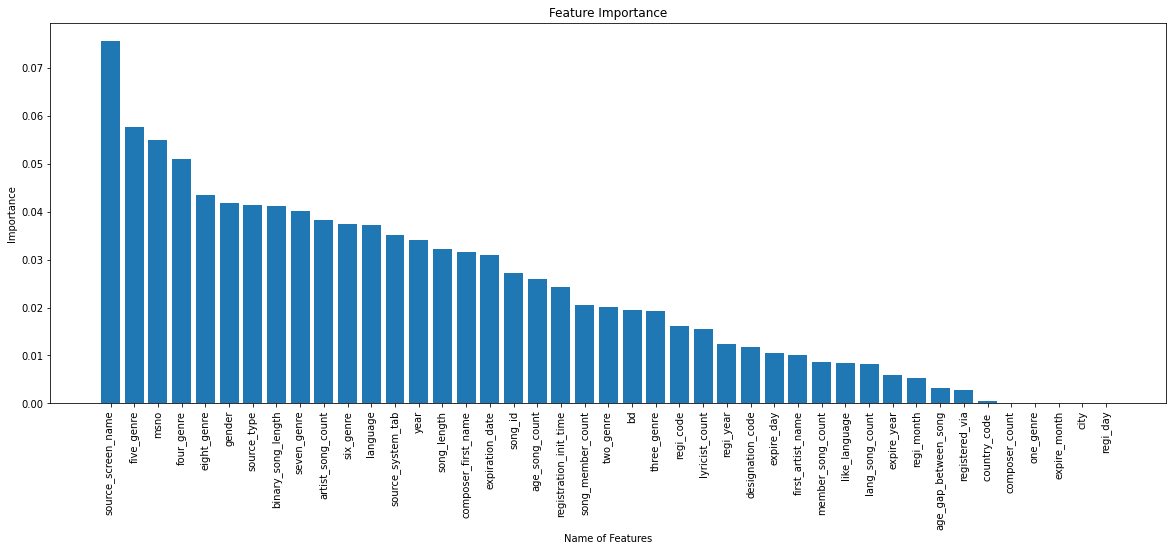

In [ ]:
plt.figure(figsize= (20,7))
plt.bar( rf_feature_impo['features'] , rf_feature_impo['importance'])
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.xlabel('Name of Features')
plt.show()

## Наблюдения
* Видим, что созданные нами признаки имеют неплохой уровень важности
* country_code , composer_count , one_genre ,expire_month ,city , regi_day , age_gap_between_song - практичестики не вносят вклада в предсказания, поэтому их следует удалить перед обучением классификаторов.

# Сжатие пространства признаков с помощью PCA (не было использовано)

In [ ]:
pca =  PCA(n_components=20)
pca_train = pca.fit_transform(data)

for i in range(20):
    data['pca_feature'+ str(i)] = pca_train[:, i]
    #test_new['pca_feature'+ str(i)]  = pca_test[:, i]

In [ ]:
clf = RandomForestClassifier()
clf.fit(data , y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# get feature importance
feature_impo = clf.feature_importances_.argsort()
features = data.columns[feature_impo]

rf_feature_impo = pd.DataFrame({ 'features' : features,'importance' : clf.feature_importances_ })
rf_feature_impo = rf_feature_impo.sort_values('importance' , ascending=False)
rf_feature_impo.head(3)

,features,importance
60,source_screen_name,0.054622
41,pca_feature7,0.049781
3,five_genre,0.038102


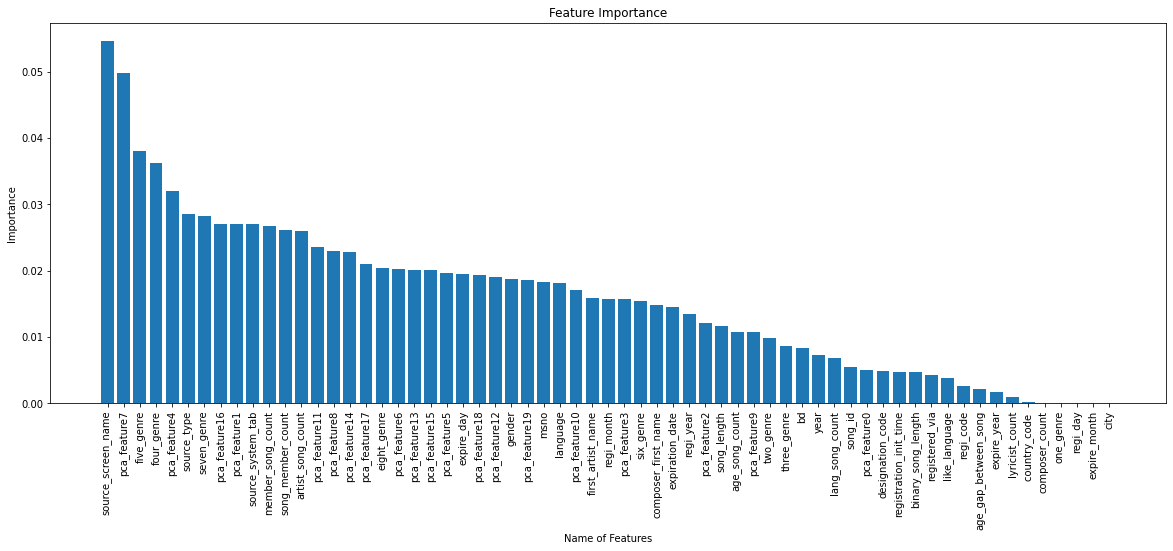

In [ ]:
plt.figure(figsize= (20,7))
plt.bar( rf_feature_impo['features'] , rf_feature_impo['importance'])
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.xlabel('Name of Features')
plt.show()